<span style='font-family:serif'> <span style='color:#0066cc'> <font size="8"> **Import datasets**
        
<span style='font-family:serif'> <font size="4.5"> Here we show how to import any Ocean General Circulation Model data set. GCM model output come with some grid variables but not all, and with their own naming conventions. The following step-by-step instructions of how to exploit some of oceanspy methods to sample model output.

In [1]:
import xarray as xr
import oceanspy as ospy
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from xgcm.autogenerate import generate_grid_ds

In [2]:
ds = xr.open_dataset('/home/idies/workspace/poseidon/data10_01/HyCOM', engine='zarr')

In [3]:
ds

<xarray.Dataset>
Dimensions:  (time: 902, lat: 1251, lon: 701, Z: 101)
Coordinates:
  * Z        (Z) float64 -0.0 -2.0 -4.0 -6.0 ... -5.5e+03 -6e+03 -7e+03 -8e+03
  * lat      (lat) float64 23.0 23.02 23.04 23.06 ... 47.94 47.96 47.98 48.0
  * lon      (lon) float64 -143.0 -143.0 -142.9 -142.9 ... -115.1 -115.0 -115.0
  * time     (time) datetime64[ns] 2019-10-01T12:00:00 ... 2019-11-10T12:00:00
Data variables:
    Eta      (time, lat, lon) float32 ...
    S        (time, Z, lat, lon) float32 ...
    T        (time, Z, lat, lon) float32 ...
    U        (time, Z, lat, lon) float32 ...
    V        (time, Z, lat, lon) float32 ...
Attributes:
    Conventions:               CF-1.0 NAVO_netcdf_v1.0
    NCO:                       "4.5.2"
    classification_authority:  not applicable
    classification_level:      UNCLASSIFIED
    distribution_statement:    Approved for public release. Distribution unli...
    downgrade_date:            not applicable
    field_type:                instantaneous
    history:                   Wed Oct  2 06:29:05 2019: ncks -d lon,-143.0,-...
    institution:               Naval Oceanographic Office
    source:                    HYCOM archive file

In [4]:
ds = generate_grid_ds(ds, {'X':'lon', 'Y': 'lat', 'Z': 'Z'}).isel(lon=slice(0, -1), lat=slice(0, -1), Z=slice(0, -1))
ds = ds.rename({'lon': 'X', 'lat': 'Y', 'lon_left': 'Xp1', 'lat_left': 'Yp1', 'Z_left': 'Zp1'})
lon_c, lat_c = np.meshgrid(ds.X, ds.Y)
lon_g, lat_g = np.meshgrid(ds.Xp1, ds.Yp1)

# coordinate must be 2d
XC = xr.DataArray(lon_c, dims=['Y', 'X'])
YC = xr.DataArray(lat_c, dims=['Y', 'X'])

XG = xr.DataArray(lon_g, dims=['Yp1', 'Xp1'])
YG = xr.DataArray(lat_g, dims=['Yp1', 'Xp1'])

ds['XC'], ds['YC'] = XC, YC
ds['XG'], ds['YG'] = XG, YG

ds = ds.set_coords(['XC', 'YC', 'XG', 'YG'])

In [5]:
od = ospy.OceanDataset(ds)

grid_coords = {
    "Y": {"Y": None, "Yp1": 0.5},
    "X": {"X": None, "Xp1": 0.5},
    "Z": {"Z": None, "Zp1": 0.5},
    "time": {"time": -0.5}
}
grid_coords = {"add_midp": True, "overwrite": True, "grid_coords": grid_coords}

od = od.set_grid_coords(**grid_coords)

od = od.set_name('HyCOM dataset')
od = od.set_projection('Mercator')
od = od.set_description('Sample data (snapshots) off the Northern California Coast from a (1/25 deg) numerical simulation covering the California Coast using the HyCOM model. The original grid has 41 (isopycnal) layers but these files were interpolated to 101 vertical levels.')

# look at a horizontal section

In [6]:
cutout_kwargs = {
    'timeRange': ds.time[0],
}

Xmoor = np.linspace(-130, -122, 10)
Ymoor = np.linspace(35, 37.5, 10)


In [7]:
od_moor = od.subsample.mooring_array(Xmoor=Xmoor, Ymoor=Ymoor, **cutout_kwargs)

Cutting out the oceandataset.
Extracting mooring array.


Cutting out the oceandataset.
Computing weighted_mean.


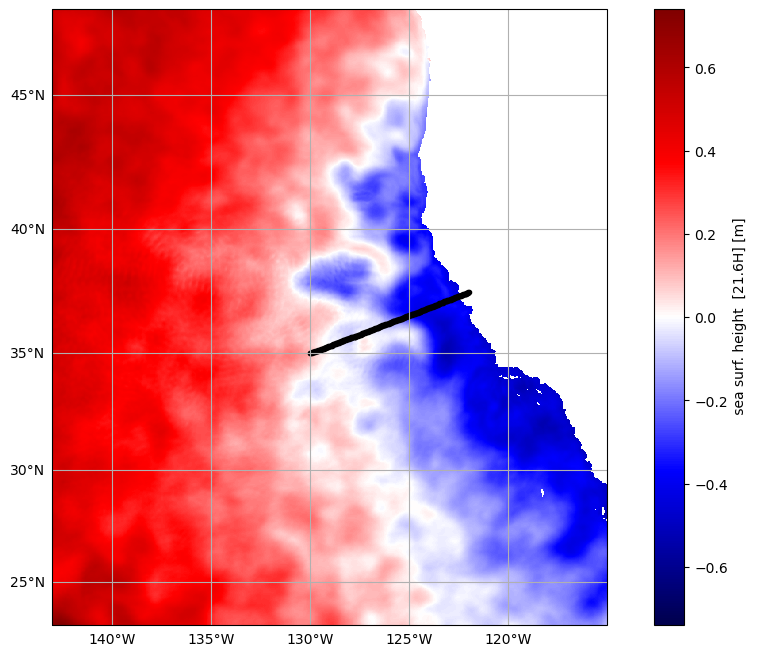

In [8]:
fig = plt.figure(figsize=(12, 8))
ax = od.plot.horizontal_section(varName="Eta", meanAxes='time', cutout_kwargs = cutout_kwargs, cmap='seismic')
XC = od_moor.dataset["XC"].squeeze()
YC = od_moor.dataset["YC"].squeeze()
ax.plot(XC, YC, "k.", transform=ccrs.PlateCarree());

Cutting out the oceandataset.
Computing weighted_mean.


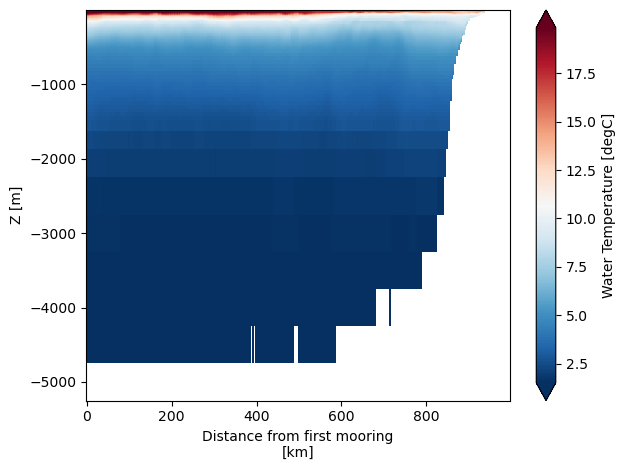

In [9]:
ax = od_moor.plot.vertical_section(
    varName="T",
    meanAxes="time",
    robust=True,
    cmap="RdBu_r",
    cutout_kwargs={'ZRange': [0, -5000]},
)

Cutting out the oceandataset.
Computing weighted_mean.


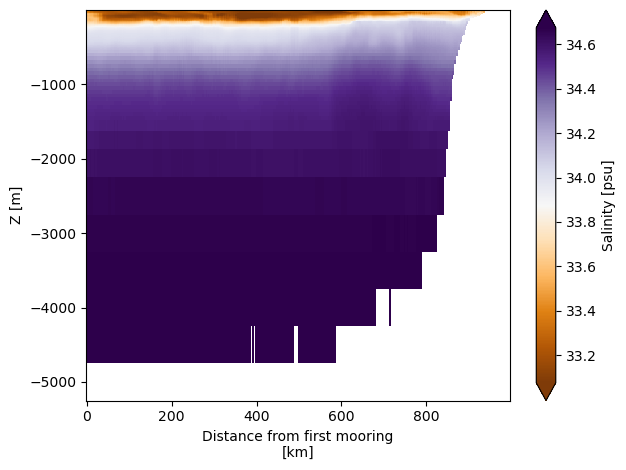

In [10]:
ax = od_moor.plot.vertical_section(
    varName="S",
    meanAxes="time",
    robust=True,
    cmap="PuOr",
    cutout_kwargs={'ZRange': [0, -5000]},
)